# 모듈 import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

주식 데이터 불러오기

In [4]:
pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import FinanceDataReader as fdr

In [355]:
pd.options.display.float_format = '{:.10f}'.format

#1. 코스피 200 지수 예측

데이터 불러오기

In [295]:
samsung = fdr.DataReader('005930','2010')[['Change']]
kospi200_등락률 = pd.read_excel('/content/drive/MyDrive/data_1429_20221026.xlsx')['등락률'].array
nasdaq= fdr.DataReader('IXIC', '2010')[['Open','Close','Volume']]

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


데이터합치기

In [344]:
df = pd.concat([samsung, nasdaq], axis = 1)

In [345]:
# 미국 시장만 열린 경우는 drop
df = df.dropna(subset = ['Change'])

In [346]:
df['코스피200_등락률'] = kospi200_등락률

In [347]:
df.columns = ['삼성전자_등락률','나스닥_시가','나스닥_종가','나스닥_거래량','코스피200_등락률']

In [1]:
df

NameError: ignored

In [349]:
df = df.interpolate(method = 'linear')

In [351]:
df['나스닥_시가대비_종가변화율'] = (df['나스닥_종가']-df['나스닥_시가'])/df['나스닥_시가']


In [352]:
df = df.drop(['나스닥_시가','나스닥_종가'],axis=1)

In [694]:
df

,삼성전자_등락률,나스닥_거래량,코스피200_등락률,나스닥_시가대비_종가변화율
Date,,,,
2010-01-04,0.0125156446,1931380000.0000000000,1.1600000000,0.0061061495
2010-01-05,0.0160692213,2367860000.0000000000,0.0400000000,0.0006240886
2010-01-06,0.0231143552,2253340000.0000000000,1.0000000000,-0.0028685897
2010-01-07,-0.0332936980,2270050000.0000000000,-0.0100000000,0.0008528652
2010-01-08,0.0098400984,2145390000.0000000000,-0.9200000000,0.0108757949
...,...,...,...,...
2022-10-20,-0.0053763441,4628010000.0000000000,0.6100000000,-0.0039944331
2022-10-21,0.0072072072,4706440000.0000000000,-1.5000000000,0.0268228644
2022-10-24,0.0286225403,4808710000.0000000000,0.8200000000,0.0078714903


3일치 미래 예측하기

### 삼성전자 종가 3일 test data 만들기

단일칼럼 스케일링

In [660]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = df['삼성전자_등락률'].values.reshape(-1,1)
std.fit(X)
scaled_samsung = std.transform(X)
scaled_samsung = pd.DataFrame(scaled_samsung, columns = ['삼성전자_등락률'])


In [581]:
def sampling(sequence, n_steps):
  X, Y = list(), list()

  for i in range(len(sequence)):

    sam = i + n_steps
    if sam > len(sequence)-1:
      break
    x, y = sequence[i:sam], sequence[sam]

    X.append(x)

    Y.append(y)
    
  return np.array(X), np.array(Y)

In [582]:
n_steps = 3
X, y = sampling(scaled_samsung['삼성전자_등락률'].tolist(), n_steps)

In [583]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [584]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [585]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 50)                10400     
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [586]:
model.fit(X, y, epochs=20, verbose=2)

Epoch 1/20
99/99 - 2s - loss: 1.0004 - 2s/epoch - 17ms/step
Epoch 2/20
99/99 - 0s - loss: 0.9966 - 334ms/epoch - 3ms/step
Epoch 3/20
99/99 - 0s - loss: 0.9953 - 330ms/epoch - 3ms/step
Epoch 4/20
99/99 - 0s - loss: 0.9948 - 340ms/epoch - 3ms/step
Epoch 5/20
99/99 - 0s - loss: 0.9950 - 358ms/epoch - 4ms/step
Epoch 6/20
99/99 - 0s - loss: 0.9937 - 332ms/epoch - 3ms/step
Epoch 7/20
99/99 - 0s - loss: 0.9934 - 334ms/epoch - 3ms/step
Epoch 8/20
99/99 - 0s - loss: 0.9925 - 351ms/epoch - 4ms/step
Epoch 9/20
99/99 - 0s - loss: 0.9926 - 361ms/epoch - 4ms/step
Epoch 10/20
99/99 - 0s - loss: 0.9932 - 329ms/epoch - 3ms/step
Epoch 11/20
99/99 - 0s - loss: 0.9924 - 348ms/epoch - 4ms/step
Epoch 12/20
99/99 - 0s - loss: 0.9919 - 330ms/epoch - 3ms/step
Epoch 13/20
99/99 - 0s - loss: 0.9913 - 348ms/epoch - 4ms/step
Epoch 14/20
99/99 - 0s - loss: 0.9916 - 346ms/epoch - 3ms/step
Epoch 15/20
99/99 - 0s - loss: 0.9913 - 325ms/epoch - 3ms/step
Epoch 16/20
99/99 - 0s - loss: 0.9912 - 354ms/epoch - 4ms/step
Epo

In [587]:
x_test1 = np.array([1.6634624669,0.1731297183,1.7132620516])
x_test1 = x_test1.reshape((1, 3, 1))
day1 = model.predict(x_test1)
day1

1/1 [==============================] - 0s 201ms/step


array([[-0.02329458]], dtype=float32)

In [590]:
x_test2 = np.array([0.1731297183,1.7132620516,-0.02329458])
x_test2 = x_test2.reshape((1, 3, 1))
day2 = model.predict(x_test2)
day2

1/1 [==============================] - 0s 25ms/step


array([[-0.08310015]], dtype=float32)

In [592]:
x_test3 = np.array([1.7132620516,-0.02329458,-0.08310015])
x_test3 = x_test3.reshape((1, 3, 1))
day3 = model.predict(x_test3)
day3

1/1 [==============================] - 0s 38ms/step


array([[-0.11822923]], dtype=float32)

### 나스닥 시가대비 종가변화율 3일 test data 만들기

단일 칼럼 스케일링

In [661]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = df['나스닥_시가대비_종가변화율'].values.reshape(-1,1)
std.fit(X)
scaled_ratio = std.transform(X)
scaled_ratio = pd.DataFrame(scaled_ratio, columns = ['나스닥_시가대비_종가변화율'])


In [630]:
n_steps = 3
X, y = sampling(scaled_ratio['나스닥_시가대비_종가변화율'].tolist(), n_steps)

In [631]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [632]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [633]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 50)                10400     
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [634]:
model.fit(X, y, epochs=20, verbose=2)

Epoch 1/20
99/99 - 2s - loss: 1.0020 - 2s/epoch - 18ms/step
Epoch 2/20
99/99 - 0s - loss: 0.9965 - 336ms/epoch - 3ms/step
Epoch 3/20
99/99 - 0s - loss: 0.9954 - 348ms/epoch - 4ms/step
Epoch 4/20
99/99 - 0s - loss: 0.9934 - 344ms/epoch - 3ms/step
Epoch 5/20
99/99 - 0s - loss: 0.9921 - 351ms/epoch - 4ms/step
Epoch 6/20
99/99 - 0s - loss: 0.9923 - 334ms/epoch - 3ms/step
Epoch 7/20
99/99 - 0s - loss: 0.9913 - 341ms/epoch - 3ms/step
Epoch 8/20
99/99 - 0s - loss: 0.9903 - 345ms/epoch - 3ms/step
Epoch 9/20
99/99 - 0s - loss: 0.9893 - 331ms/epoch - 3ms/step
Epoch 10/20
99/99 - 0s - loss: 0.9873 - 355ms/epoch - 4ms/step
Epoch 11/20
99/99 - 0s - loss: 0.9879 - 333ms/epoch - 3ms/step
Epoch 12/20
99/99 - 0s - loss: 0.9877 - 347ms/epoch - 4ms/step
Epoch 13/20
99/99 - 0s - loss: 0.9875 - 356ms/epoch - 4ms/step
Epoch 14/20
99/99 - 0s - loss: 0.9863 - 338ms/epoch - 3ms/step
Epoch 15/20
99/99 - 0s - loss: 0.9866 - 351ms/epoch - 4ms/step
Epoch 16/20
99/99 - 0s - loss: 0.9845 - 352ms/epoch - 4ms/step
Epo

In [636]:
x_test1 = np.array([0.7735742308,1.8341016596,1.8341016596])
x_test1 = x_test1.reshape((1, 3, 1))
day1 = model.predict(x_test1)
day1

1/1 [==============================] - 0s 191ms/step


array([[-0.09108626]], dtype=float32)

In [637]:
x_test2 = np.array([1.8341016596,0.00777331,-0.09108626])
x_test2 = x_test2.reshape((1, 3, 1))
day2 = model.predict(x_test2)
day2

1/1 [==============================] - 0s 38ms/step


array([[-0.05429615]], dtype=float32)

In [638]:
x_test3 = np.array([0.00777331,-0.09108626,-0.05429615])
x_test3 = x_test3.reshape((1, 3, 1))
day3 = model.predict(x_test3)
day3

1/1 [==============================] - 0s 37ms/step


array([[-0.01191157]], dtype=float32)

###나스닥 거래량 test 3일 데이터 만들기

In [662]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = df['나스닥_거래량'].values.reshape(-1,1)
std.fit(X)
scaled_volume = std.transform(X)
scaled_volume = pd.DataFrame(scaled_volume, columns = ['나스닥_거래량'])


In [619]:
n_steps = 3
X, y = sampling(scaled_volume['나스닥_거래량'].tolist(), n_steps)

In [620]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [621]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [622]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 50)                10400     
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [623]:
model.fit(X, y, epochs=20, verbose=4)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [626]:
x_test1 = np.array([1.7398288156,1.9966722879,1.9966722879])
x_test1 = x_test1.reshape((1, 3, 1))
day1 = model.predict(x_test1)
day1

1/1 [==============================] - 0s 23ms/step


array([[2.1694117]], dtype=float32)

In [627]:
x_test2 = np.array([1.9966722879,1.9966722879,2.1694117])
x_test2 = x_test2.reshape((1, 3, 1))
day2 = model.predict(x_test2)
day2

1/1 [==============================] - 0s 19ms/step


array([[2.3319905]], dtype=float32)

In [628]:
x_test3 = np.array([1.9966722879,2.1694117,2.3319905])
x_test3 = x_test3.reshape((1, 3, 1))
day3 = model.predict(x_test3)
day3

1/1 [==============================] - 0s 21ms/step


array([[2.4567845]], dtype=float32)

### 데이터프레임 다시 만들기(스케일링)

In [ ]:
#기존 데이터프레임
df

In [667]:
scale_df = pd.concat([scaled_samsung,scaled_ratio,scaled_volume],axis=1)

In [668]:
scale_df['코스피200_등락률'] = kospi200_등락률

In [672]:
scale_df.loc['3162'] = [-0.02329458,-0.09108626,2.1694117,0]
scale_df.loc['3163'] = [-0.08310015,-0.05429615,2.3319905,0]
scale_df.loc['3164'] = [-0.11822923,-0.01191157,2.4567845,0]


In [673]:
scale_df

,삼성전자_등락률,나스닥_시가대비_종가변화율,나스닥_거래량,코스피200_등락률
0,0.7087867027,0.5954547934,-0.4791275814,1.1600000000
1,0.9194116190,0.0423255652,-0.1425203489,0.0400000000
2,1.3369854820,-0.3100788508,-0.2308365610,1.0000000000
3,-2.0063900711,0.0654086705,-0.2179500442,-0.0100000000
4,0.5502037505,1.0767026887,-0.3140860816,-0.9200000000
...,...,...,...,...
3160,0.1731297183,1.8341016596,1.9966722879,-0.2900000000
3161,1.7132620516,1.8341016596,1.9966722879,0.7300000000
3162,-0.0232945800,-0.0910862600,2.1694117000,0.0000000000
3163,-0.0831001500,-0.0542961500,2.3319905000,0.0000000000


### 모델링(코스피200지수)

In [674]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [678]:
train_feature = scale_df.iloc[:-6,:3]
train_label = scale_df.iloc[:-6,-1] 
test_feature = scale_df.iloc[-6:,:3]
test_label = scale_df.iloc[-6:,:-1]


In [679]:
train_feature, train_label = make_dataset(train_feature, train_label, 3)
test_feature, test_label = make_dataset(test_feature, test_label, 3)

In [680]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [681]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [682]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])

Epoch 1/200
158/158 [==============================] - 3s 9ms/step - loss: 1.2059 - val_loss: 1.2256
Epoch 2/200
158/158 [==============================] - 1s 5ms/step - loss: 1.2026 - val_loss: 1.2273
Epoch 3/200
158/158 [==============================] - 1s 5ms/step - loss: 1.2004 - val_loss: 1.2269
Epoch 4/200
158/158 [==============================] - 1s 4ms/step - loss: 1.1996 - val_loss: 1.2246
Epoch 5/200
158/158 [==============================] - 1s 5ms/step - loss: 1.1989 - val_loss: 1.2266
Epoch 6/200
158/158 [==============================] - 1s 4ms/step - loss: 1.1976 - val_loss: 1.2247
Epoch 7/200
158/158 [==============================] - 1s 5ms/step - loss: 1.1964 - val_loss: 1.2269
Epoch 8/200
158/158 [==============================] - 1s 5ms/step - loss: 1.1955 - val_loss: 1.2281
Epoch 9/200
158/158 [==============================] - 1s 5ms/step - loss: 1.1936 - val_loss: 1.2285


In [683]:
valpred = model.predict(x_valid)

20/20 [==============================] - 0s 2ms/step


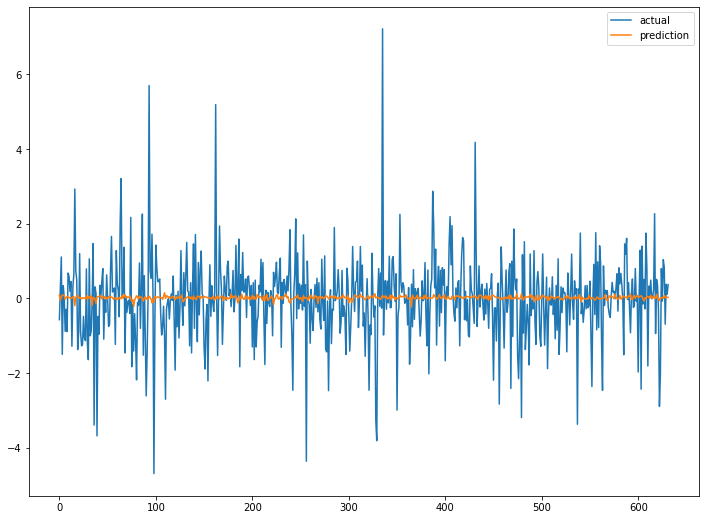

In [684]:
plt.figure(figsize=(12, 9))
plt.plot(y_valid, label='actual')
plt.plot(valpred, label='prediction')
plt.legend()
plt.show()

3일 예측하기

In [685]:
result = model.predict(test_feature)

1/1 [==============================] - 0s 30ms/step


In [686]:
# 최종 예측 결과
result

array([[-0.10356539],
       [ 0.07012472],
       [ 0.05954309]], dtype=float32)

# 2. 코스피 종목 예측(db하이텍, 한미반도체)

## 데이터프레임 만들기

데이터불러오기

In [440]:
samsung = fdr.DataReader('005930','2009-12-28')[['Change']] # 주도주
hynix = fdr.DataReader('000660', '2009-12-28')[['Change']] # 주도주 

db_hitech = fdr.DataReader('000990','2010')[['Change']] #비주도주
hanmi = fdr.DataReader('042700','2010')[['Change']] #비주도주


편의상 kospi_df에 예측하고자 하는 두 종목(db하이텍,한미반도체)을 모두 넣었지만, 모델 학습 및 예측 과정에서는 하나씩만 사용할 예정.

In [441]:
kospi_df = pd.concat([samsung,hynix,db_hitech,hanmi], axis = 1)


In [442]:
kospi_df.columns = ['삼성전자','하이닉스','db','hanmi']

삼성전자와 하이닉스 같은 주도주가 먼저 주가에 영향을 받고, 시간차를 둬서 비 주도주에 영향을 준다는 논리를 통해 3일 차의 시간 간격을 둠.

In [443]:
kospi_df[['삼성전자','하이닉스']] = kospi_df[['삼성전자','하이닉스']].shift(3)

In [444]:
kospi_df = kospi_df.iloc[3:]

shift(3)으로 인해 뒤로 밀린 데이터 넣어주기

In [445]:
kospi_df.loc['2022-10-27 00:00:00'] = [0.0286225403,0.0143646409,0,0]
kospi_df.loc['2022-10-28 00:00:00'] = [0.0034782609,0.0185185185,0,0]
kospi_df.loc['2022-10-29 00:00:00'] = [0.0294627383,0.0042780749,0,0]

In [446]:
kospi_df.columns = ['삼성전자_등락률','하이닉스_등락률','db하이텍_등락률','한미반도체_등락률']

In [449]:
kospi_df

,삼성전자_등락률,하이닉스_등락률,db하이텍_등락률,한미반도체_등락률
Date,,,,
2010-01-04 00:00:00,-0.0037974684,-0.0044843049,0.0608203678,0.0714285714
2010-01-05 00:00:00,-0.0012706480,0.0000000000,0.0066666667,-0.0416666667
2010-01-06 00:00:00,0.0165394402,0.0427927928,-0.0185430464,0.0217391304
2010-01-07 00:00:00,0.0125156446,0.0410367171,0.0067476383,-0.0496453901
2010-01-08 00:00:00,0.0160692213,-0.0311203320,0.0067024129,0.0582089552
...,...,...,...,...
2022-10-25 00:00:00,-0.0053763441,-0.0290635091,0.0560975610,0.0292887029
2022-10-26 00:00:00,0.0072072072,0.0033259424,0.0115473441,-0.0203252033
2022-10-27 00:00:00,0.0286225403,0.0143646409,0.0000000000,0.0000000000


##스케일링

In [486]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = kospi_df.iloc[:,:2]
std.fit(X)
scaled_df = std.transform(X)
scaled_df = pd.DataFrame(scaled_df)

In [492]:
db_array = kospi_df.iloc[:,-1].array
hanmi_array = kospi_df.iloc[:,-2].array

In [493]:
scaled_df['db'] = db_array
scaled_df['hanmi'] = hanmi_array

In [495]:
scaled_df.columns = ['삼성전자_등락률','하이닉스_등락률','db하이텍_등락률','한미반도체_등락률']

In [496]:
scaled_df

,삼성전자_등락률,하이닉스_등락률,db하이텍_등락률,한미반도체_등락률
0,-0.2583779733,-0.2193859139,0.0714285714,0.0608203678
1,-0.1085622659,-0.0309626921,-0.0416666667,0.0066666667
2,0.9474016036,1.7671210710,0.0217391304,-0.0185430464
3,0.7088299151,1.6933336164,-0.0496453901,0.0067476383
4,0.9195222238,-1.3385885779,0.0582089552,0.0067024129
...,...,...,...,...
3160,-0.3519898468,-1.2521642190,0.0292887029,0.0560975610
3161,0.3940915505,0.1087880123,-0.0203252033,0.0115473441
3162,1.6638111445,0.5726162257,0.0000000000,0.0000000000
3163,0.1730015413,0.7471554268,0.0000000000,0.0000000000


##모델링 1(db하이텍)

In [507]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [508]:
train_feature = scaled_df.iloc[:-6,:2]
train_label = scaled_df.iloc[:-6,-2] # db하이텍
test_feature = scaled_df.iloc[-6:,:2]
test_label = scaled_df.iloc[-6:,:-2]


In [509]:
train_feature, train_label = make_dataset(train_feature, train_label, 3)
test_feature, test_label = make_dataset(test_feature, test_label, 3)

In [510]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [511]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [512]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])

Epoch 1/200
158/158 [==============================] - 2s 6ms/step - loss: 0.0032 - val_loss: 8.6128e-04
Epoch 2/200
158/158 [==============================] - 1s 4ms/step - loss: 9.3293e-04 - val_loss: 7.4373e-04
Epoch 3/200
158/158 [==============================] - 1s 5ms/step - loss: 8.6790e-04 - val_loss: 7.2665e-04
Epoch 4/200
158/158 [==============================] - 1s 4ms/step - loss: 8.4146e-04 - val_loss: 7.1858e-04
Epoch 5/200
158/158 [==============================] - 1s 5ms/step - loss: 8.1750e-04 - val_loss: 7.0481e-04
Epoch 6/200
158/158 [==============================] - 1s 5ms/step - loss: 8.0897e-04 - val_loss: 7.0524e-04
Epoch 7/200
158/158 [==============================] - 1s 5ms/step - loss: 8.0877e-04 - val_loss: 7.3819e-04
Epoch 8/200
158/158 [==============================] - 1s 4ms/step - loss: 8.0564e-04 - val_loss: 7.1452e-04
Epoch 9/200
158/158 [==============================] - 1s 4ms/step - loss: 7.9687e-04 - val_loss: 7.0286e-04
Epoch 10/200
158/158 [=

In [513]:
valpred = model.predict(x_valid)

20/20 [==============================] - 0s 4ms/step


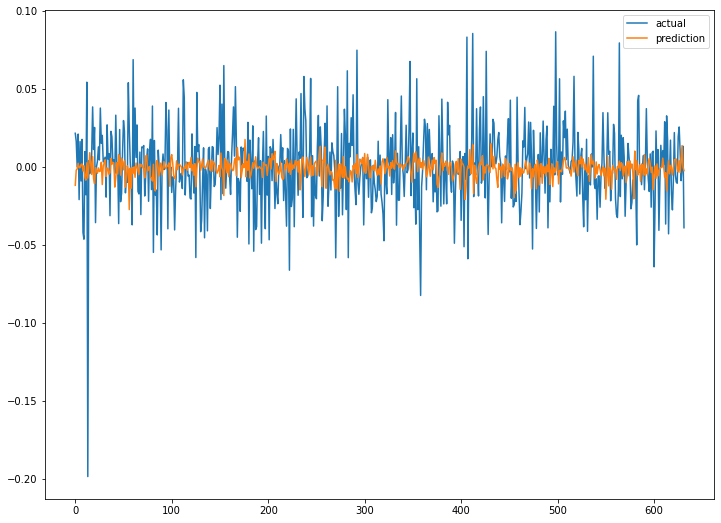

In [514]:
plt.figure(figsize=(12, 9))
plt.plot(y_valid, label='actual')
plt.plot(valpred, label='prediction')
plt.legend()
plt.show()

###3일 예측하기

In [515]:
result = model.predict(test_feature)

1/1 [==============================] - 0s 21ms/step


In [516]:
result

array([[0.00311295],
       [0.00245522],
       [0.00100459]], dtype=float32)

##모델링 2(한미반도체)

In [497]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [498]:
train_feature = scaled_df.iloc[:-6,:2]
train_label = scaled_df.iloc[:-6,-1] # 한미반도체
test_feature = scaled_df.iloc[-6:,:2]
test_label = scaled_df.iloc[-6:,:-1]


In [499]:
train_feature, train_label = make_dataset(train_feature, train_label, 3)
test_feature, test_label = make_dataset(test_feature, test_label, 3)

In [500]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [501]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [502]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])

Epoch 1/200
158/158 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 9.4662e-04
Epoch 2/200
158/158 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 9.2896e-04
Epoch 3/200
158/158 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 9.1298e-04
Epoch 4/200
158/158 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 9.0782e-04
Epoch 5/200
158/158 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 9.2706e-04
Epoch 6/200
158/158 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 9.2387e-04
Epoch 7/200
158/158 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 9.3259e-04
Epoch 8/200
158/158 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 9.2544e-04
Epoch 9/200
158/158 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 9.1644e-04


검증 set 확인하기

In [503]:
valpred = model.predict(x_valid)

20/20 [==============================] - 0s 2ms/step


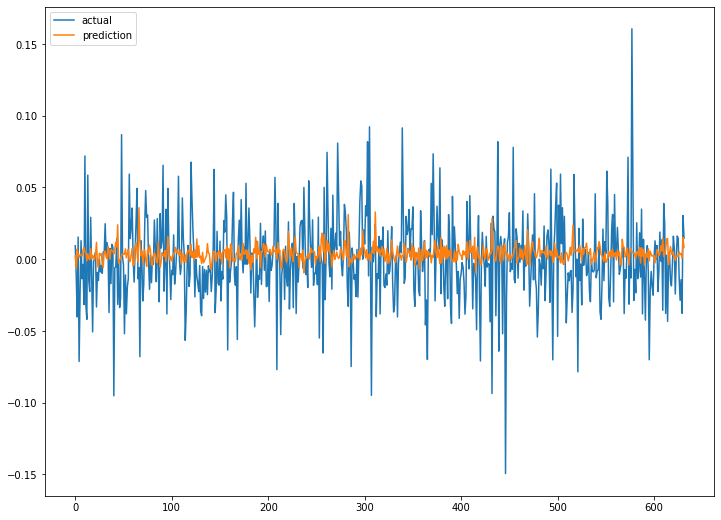

In [504]:
plt.figure(figsize=(12, 9))
plt.plot(y_valid, label='actual')
plt.plot(valpred, label='prediction')
plt.legend()
plt.show()

###3일 예측하기

In [505]:
result = model.predict(test_feature)

1/1 [==============================] - 0s 100ms/step


In [506]:
result

array([[0.00775176],
       [0.00060453],
       [0.00443166]], dtype=float32)

# 3. 코스닥 종목 예측(성우하이텍, 구영테크)

데이터 불러오기

In [206]:
kia = fdr.DataReader('000270','2009-12-28')[['Change']]
hyundai = fdr.DataReader('005380','2009-12-28')[['Change']]
sungwoo_hitech = fdr.DataReader('015750','2010')[['Change']]
gooyoung_tech = fdr.DataReader('053270','2010')[['Change']]

In [216]:
kosdaq_df = pd.concat([kia,hyundai,sungwoo_hitech,gooyoung_tech], axis = 1)

In [217]:
kosdaq_df

,Change,Change,Change,Change
Date,,,,
2009-12-28,-0.0195121951,-0.0082644628,NaN,NaN
2009-12-29,-0.0049751244,0.0041666667,NaN,NaN
2009-12-30,0.0025000000,0.0041493776,NaN,NaN
2010-01-04,0.0374064838,-0.0165289256,0.0361324858,-0.0262295082
2010-01-05,-0.0552884615,-0.0756302521,-0.0579593155,0.0213243547
...,...,...,...,...
2022-10-20,-0.0086956522,0.0029761905,-0.0570934256,0.0000000000
2022-10-21,-0.0073099415,-0.0089020772,-0.0238532110,-0.0376984127
2022-10-24,-0.0382916053,-0.0329341317,0.0281954887,0.0329896907


In [218]:
kosdaq_df.columns = ['기아','현대차','성우하이텍','구영테크']

In [219]:
kosdaq_df[['기아','현대차']] = kosdaq_df[['기아','현대차']].shift(3)

In [222]:
kosdaq_df = kosdaq_df.iloc[3:]

In [225]:
kosdaq_df.loc['2022-10-27 00:00:00'] = [-0.0382916053,-0.0329341317,0,0]
kosdaq_df.loc['2022-10-28 00:00:00'] = [0.0153139357,0.0061919505,0,0]
kosdaq_df.loc['2022-10-29 00:00:00'] = [-0.0120663650,-0.0123076923,0,0]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [226]:
kosdaq_df

,기아,현대차,성우하이텍,구영테크
Date,,,,
2010-01-04 00:00:00,-0.0195121951,-0.0082644628,0.0361324858,-0.0262295082
2010-01-05 00:00:00,-0.0049751244,0.0041666667,-0.0579593155,0.0213243547
2010-01-06 00:00:00,0.0025000000,0.0041493776,0.0082262211,0.0054945055
2010-01-07 00:00:00,0.0374064838,-0.0165289256,-0.0528641849,-0.0054644809
2010-01-08 00:00:00,-0.0552884615,-0.0756302521,0.0000000000,-0.0208791209
...,...,...,...,...
2022-10-25 00:00:00,-0.0086956522,0.0029761905,0.0219378428,0.0019960080
2022-10-26 00:00:00,-0.0073099415,-0.0089020772,-0.0661896243,-0.0119521912
2022-10-27 00:00:00,-0.0382916053,-0.0329341317,0.0000000000,0.0000000000


###스케일링

In [517]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X = kosdaq_df.iloc[:,:2]
std.fit(X)
scaled_df = std.transform(X)
scaled_df = pd.DataFrame(scaled_df)

In [518]:
seongwoo_array = kosdaq_df.iloc[:,-1].array
gooyeong_array = kosdaq_df.iloc[:,-2].array

In [519]:
scaled_df['seongwoo'] = seongwoo_array
scaled_df['gooyeong'] = gooyeong_array

In [522]:
scaled_df.columns = ['기아차_등락률','현대차_등락률','성우하이텍_등락률','구영테크_등락률']

In [523]:
scaled_df

,기아차_등락률,현대차_등락률,성우하이텍_등락률,구영테크_등락률
0,-0.9864627137,-0.4111307842,-0.0262295082,0.0361324858
1,-0.2725187771,0.1852739136,0.0213243547,-0.0579593155
2,0.0945991808,0.1844444407,0.0054945055,0.0082262211
3,1.8089247758,-0.8076325224,-0.0054644809,-0.0528641849
4,-2.7435050322,-3.6431197423,-0.0208791209,0.0000000000
...,...,...,...,...
3160,-0.4552411637,0.1281587822,0.0019960080,0.0219378428
3161,-0.3871862071,-0.4417214228,-0.0119521912,-0.0661896243
3162,-1.9087562257,-1.5947003422,0.0000000000,0.0000000000
3163,0.7239165900,0.2824403694,0.0000000000,0.0000000000


##모델링 1(성우하이텍)

In [524]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [526]:
train_feature = scaled_df.iloc[:-6, :2]
train_label = scaled_df.iloc[:-6, -2] # 성우하이텍 예측
test_feature = scaled_df.iloc[-6:, :2]
test_label = scaled_df.iloc[-6:, -2]


In [527]:
train_feature, train_label = make_dataset(train_feature, train_label, 3) # 이전 3일로 학습을 진행
test_feature, test_label = make_dataset(test_feature, test_label, 3)

In [528]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [532]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [539]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=4,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])

Epoch 1/20
631/631 [==============================] - 3s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/20
631/631 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/20
631/631 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/20
631/631 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/20
631/631 [==============================] - 3s 4ms/step - loss: 0.0011 - val_loss: 0.0012

In [540]:
valpred = model.predict(x_valid)

20/20 [==============================] - 0s 2ms/step


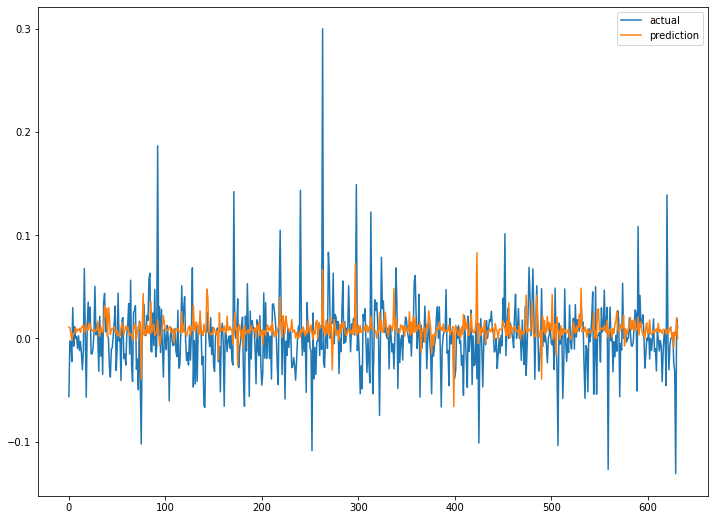

In [541]:
plt.figure(figsize=(12, 9))
plt.plot(y_valid, label='actual')
plt.plot(valpred, label='prediction')
plt.legend()
plt.show()

### 3일 예측하기

In [542]:
result = model.predict(test_feature)

1/1 [==============================] - 0s 99ms/step


In [543]:
result

array([[0.00359465],
       [0.00653047],
       [0.00755752]], dtype=float32)

##모델링 2(구영테크)

시계열 분석을 위한 window size 설정

In [544]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

총 데이터에서 6개를 제외한 데이터를 학습 및 검증 데이터로 사용하였고, 마지막 6개의 데이터를 test 데이터로 선정해 미래 3일을 예측하였다.

In [546]:
train_feature = scaled_df.iloc[:-6,:2]
train_label = scaled_df.iloc[:-6,-1] # 구영테크 예측
test_feature = scaled_df.iloc[-6:,:2]
test_label = scaled_df.iloc[-6:,-1]


In [547]:
train_feature, train_label = make_dataset(train_feature, train_label, 3) # 이전 3일로 학습을 진행
test_feature, test_label = make_dataset(test_feature, test_label, 3)

In [548]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

In [549]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [550]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
  ㅎ                  callbacks=[early_stop])

Epoch 1/20
158/158 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 7.0539e-04
Epoch 2/20
158/158 [==============================] - 1s 5ms/step - loss: 9.1639e-04 - val_loss: 7.6586e-04
Epoch 3/20
158/158 [==============================] - 1s 5ms/step - loss: 8.6718e-04 - val_loss: 7.6300e-04
Epoch 4/20
158/158 [==============================] - 1s 4ms/step - loss: 8.6156e-04 - val_loss: 7.3510e-04
Epoch 5/20
158/158 [==============================] - 1s 5ms/step - loss: 8.4579e-04 - val_loss: 7.8679e-04
Epoch 6/20
158/158 [==============================] - 1s 4ms/step - loss: 8.6766e-04 - val_loss: 7.1289e-04


In [551]:
valpred = model.predict(x_valid)

20/20 [==============================] - 0s 3ms/step


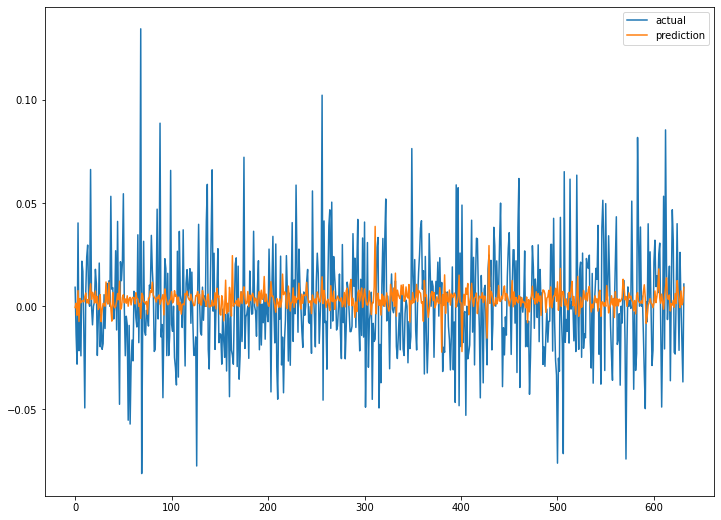

In [552]:
plt.figure(figsize=(12, 9))
plt.plot(y_valid, label='actual')
plt.plot(valpred, label='prediction')
plt.legend()
plt.show()

### 3일 예측하기

In [554]:
result = model.predict(test_feature)

1/1 [==============================] - 0s 20ms/step


In [555]:
result

array([[0.00389265],
       [0.00252058],
       [0.00788118]], dtype=float32)

# 입력 데이터 시각화

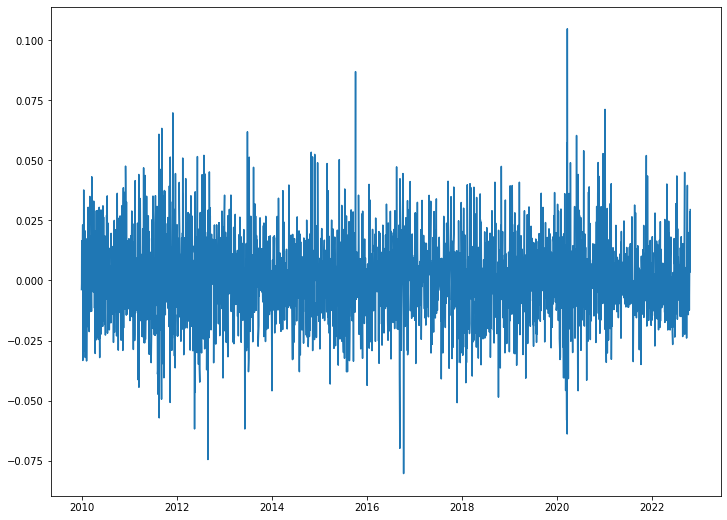

In [688]:
plt.figure(figsize=(12, 9))
plt.plot(samsung)

In [692]:
samsung.describe()

,Change
count,3165.0000000000
mean,0.0005603839
std,0.0168688560
min,-0.0803571429
25%,-0.0097656250
50%,0.0000000000
75%,0.0099502488
max,0.1047058824


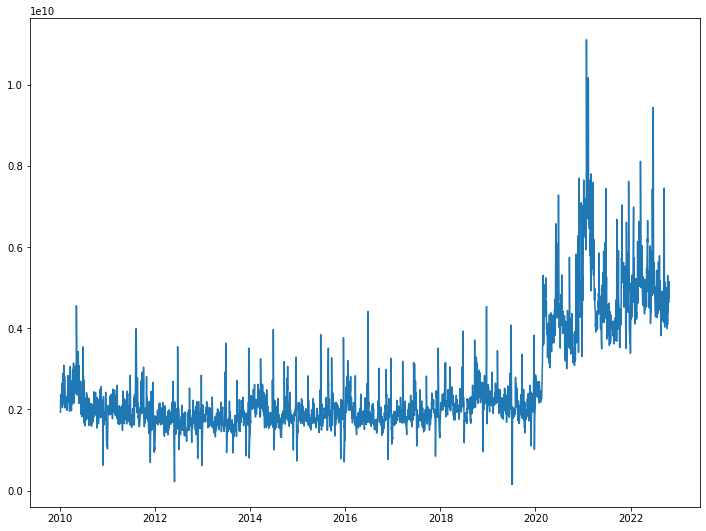

In [691]:
plt.figure(figsize=(12, 9))
plt.plot(nasdaq.Volume)

In [693]:
nasdaq.Volume.describe()

count          3226.0000000000
mean     2558102507.7495350838
std      1290942900.0299510956
min       149410000.0000000000
25%      1785210000.0000000000
50%      2025515000.0000000000
75%      2638107500.0000000000
max     11102160000.0000000000
Name: Volume, dtype: float64

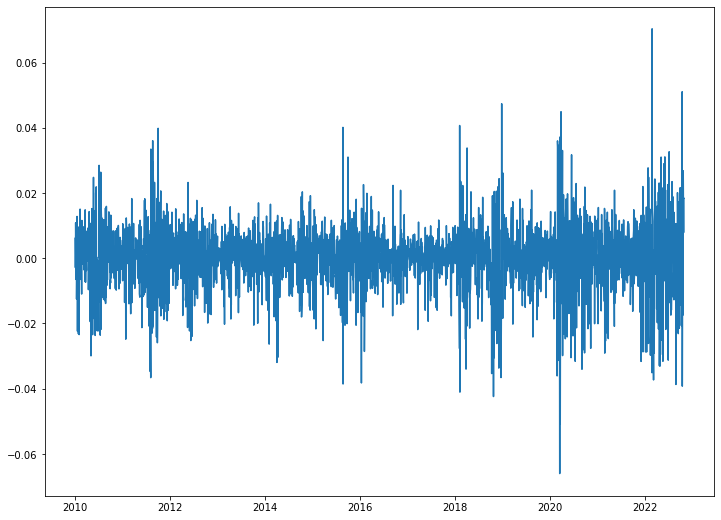

In [696]:
plt.figure(figsize=(12, 9))
plt.plot(df['나스닥_시가대비_종가변화율'])

In [697]:
df['나스닥_시가대비_종가변화율'].describe()

count   3162.0000000000
mean       0.0002046002
std        0.0099125624
min       -0.0660297532
25%       -0.0043299189
50%        0.0008130618
75%        0.0054961088
max        0.0703621237
Name: 나스닥_시가대비_종가변화율, dtype: float64

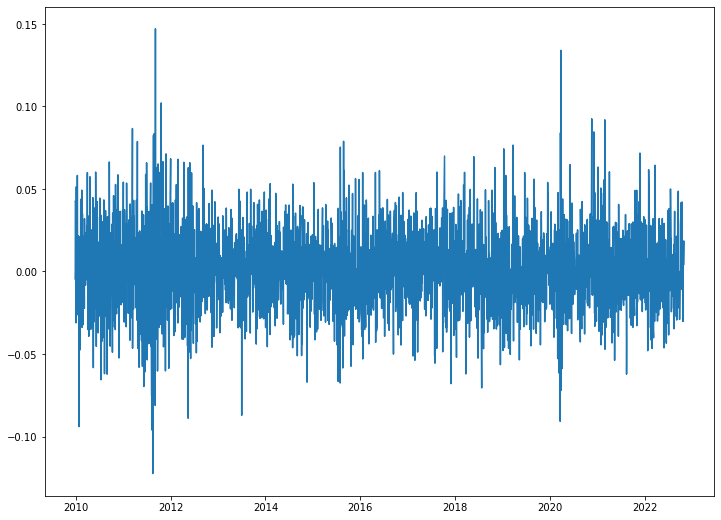

In [699]:
plt.figure(figsize=(12, 9))
plt.plot(hynix)

In [700]:
hynix.describe()

,Change
count,3165.0000000000
mean,0.0007368845
std,0.0238028704
min,-0.1224489796
25%,-0.0136411333
50%,0.0000000000
75%,0.0143884892
max,0.1470588235


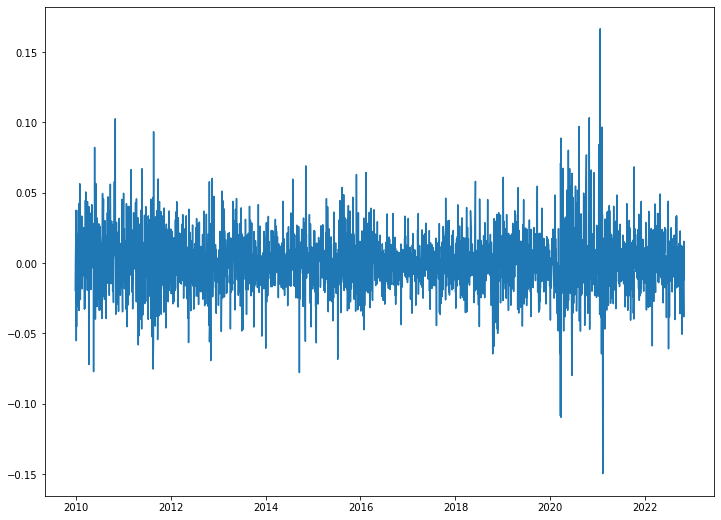

In [701]:
plt.figure(figsize=(12, 9))
plt.plot(kia)

In [702]:
kia.describe()

,Change
count,3165.0000000000
mean,0.0005738054
std,0.0203648593
min,-0.1497536946
25%,-0.0104529617
50%,0.0000000000
75%,0.0105509965
max,0.1664335664


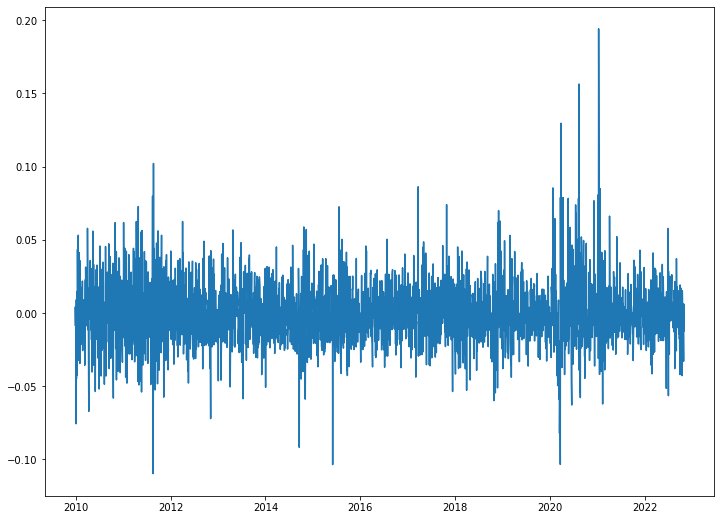

In [703]:
plt.figure(figsize=(12, 9))
plt.plot(hyundai)

In [704]:
hyundai.describe()

,Change
count,3165.0000000000
mean,0.0003049197
std,0.0208467402
min,-0.1096605744
25%,-0.0114068441
50%,0.0000000000
75%,0.0110497238
max,0.1941747573
